<a href="https://colab.research.google.com/github/karlssoj/compvis/blob/Exempel4_cats_dogs_classification_transfer_learning/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Klassificeringsexempel med faltningsnätverk (CNN) implementerat med Keras och Tensorflow </h1>

I det här simplata exemplet tränar vi in en modell att kunna se skillnad mellan X och O. I katalogen X_O_training finns 2 kataloger O och X. Vardera katalog innehåller 4 träningsbilder på X respektive O. Sedan har vi en bild i samma katalog som denna notebookfil,"test_image.jpg" som vi använder för att testa om modellen gissar rätt. Observera att för att den här modellen ska fungera krävs det bilder där X och Y fyller hela bakrunden. För att modellen ska fungera med X och Y av olika storlekar placerade på olika ställen i bakgrunden krävs en bättre dataset.

Skriptet är testkört i google colab (men kan nog även köras lokalt). Om du kör på colab.

**Laddar ner cats & dogs dataset**

In [ ]:
!wget  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

**Packer upp ZIP-filen**

In [ ]:
!unzip kagglecatsanddogs_5340.zip

**Tar bort de "korrupta" bildfilerna**

In [4]:
!rm /content/PetImages/Cat/666.jpg
!rm /content/PetImages/Dog/11702.jpg

<b> 2. Importerar ImageDataGenerator från Keras-biblioteket för att kunna hantera träningsbilderna i X_O_training/o och X_O_training/x

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

<b> 4. Läser in alla träningsbilder på X och O från respektive kataloger i X_O_training-katalogen. Alla bilder får storleken 100x100 pixlar

In [17]:
train_image_gen = image_gen.flow_from_directory(
    "/content/PetImages",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

Found 24998 images belonging to 2 classes.


<b> 5. Träningsbilderna har automatiskt markerats enligt namnet på katalogerna de finns sparade i, dvs. O har labeln 0 och X har labeln 1

In [23]:
print(train_image_gen.class_indices)

{'Cat': 0, 'Dog': 1}


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Frys basmodellen så att dess vikter inte förändras under träningen
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # För att minska överanpassning

output_layer = Dense(1, activation="sigmoid")(x)  # Binary classification
model = Model(inputs=base_model.input, outputs=output_layer)

<b> 11. "Kompilerar" modellen. Optimizer är den metod man vill använda för att optimera alla vikter i nätet. Adam är en variant av gradient descent. Loss definierar "loss function", dvs. vad man vill använda för metod för att beräkna feluppskattningen under inträningen.

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",  # Correct loss function for 2-class problem
    metrics=["accuracy"]
)

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

<b> 12. Startar själva inträningen på testdataset:en. Epochs definierar hur många ggr inlärningsalgoritmen kommer att gå igenom hela dataset:en.

In [ ]:
results = model.fit(train_image_gen, epochs=50)

Epoch 1/50
252/391 ━━━━━━━━━━━━━━━━━━━━ 2:00 870ms/step - accuracy: 0.4961 - loss: 0.7107

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


391/391 ━━━━━━━━━━━━━━━━━━━━ 356s 848ms/step - accuracy: 0.4967 - loss: 0.7062
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 315s 805ms/step - accuracy: 0.5015 - loss: 0.6933
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 320s 817ms/step - accuracy: 0.4995 - loss: 0.6932
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 317s 810ms/step - accuracy: 0.5026 - loss: 0.6932
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 320s 818ms/step - accuracy: 0.4978 - loss: 0.6933
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 315s 806ms/step - accuracy: 0.5027 - loss: 0.6932
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 313s 801ms/step - accuracy: 0.4973 - loss: 0.6932
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 320s 818ms/step - accuracy: 0.4974 - loss: 0.6932
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 311s 796ms/step - accuracy: 0.5024 - loss: 0.6932
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 306s 782ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 307s 784ms/step - accuracy: 0.5011 - loss: 0.6932
Epoch 12/50
391/391

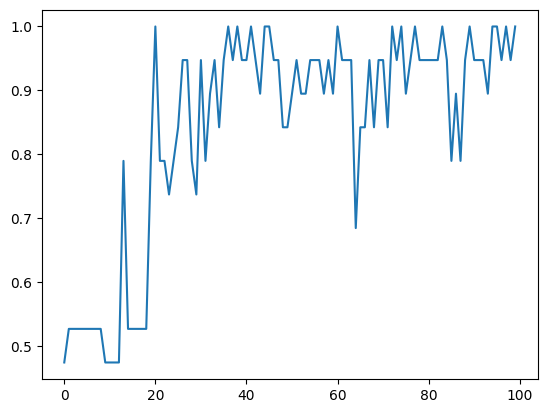

In [ ]:
plt.plot(results.history['accuracy'])

<b> 13. Vi laddar in en testbild (En bild som inte finns i träningsdataset:en) för att se hur bra vår modell fungerar! Observera att i detta simpla exempel så måste X eller O täcka mer eller mindre hela bilden och bakgrunden bör (antagligen) vara vit för att det ska fungera. För att få modellen att hitta X eller O även om de är skrivna i mindre storlek och i olika bakgrunder så måste träningsdataset:en utökas.

In [ ]:
import numpy as np
import keras.utils as image
test_image = '/content/compvis/test_image1.jpg'
test_image = image.load_img(test_image, target_size=(100,100)) #laddar testbilden och sätter storleken till samma som träningsbilderna
test_image = image.img_to_array(test_image)                    #konverterar till array-format

test_image = np.expand_dims(test_image, axis=0)
test_image = test_image/255                                    #Ändrar pixelvärden från 8-bitar (0-255) till värden mellan 0 och 1

<b> 14. Vi startar "predikteringen" dvs. Som svar får vi konfidensvärden som berättar hur stor sannolikhten är att bilden innehåller ett X och hur stor sannolikheten är att bilden innehåller ett O

In [ ]:
prob = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [ ]:
print(prob)

[[0.84596676 0.12440345]]


In [ ]:
print("Sannolikheten att testbilden innehåller O: " + str(prob[0][0]))
print("Sannolikheten att testbilden innehåller X: " + str(prob[0][1]))

Sannolikheten att testbilden innehåller O: 0.84596676
Sannolikheten att testbilden innehåller X: 0.12440345
